# Montevideo: Dataset building

In this notebook we build a dataset consisting of 300x300 RGB chips of an RGB mosaic satellite image. This image is a mosaic built from a WorldView-2 scene of Montevideo, Uruguay, acquired on 2017. Chips outside of AOI and on ocean are discarded.

The methodology consists of building a multilabel classifier of 3 classes:
* Urban areas
* Rural areas
* Schools

To designate urban and rural areas, we are using shapefiles from the [Open Data Catalog](http://datos.gub.uy/) 
* [Urban lots](https://catalogodatos.gub.uy/dataset/shapes-del-parcelario-rural-y-urbano/resource/541d8db5-1ceb-40dd-9898-706d85209d04)
* [Rural lots](https://catalogodatos.gub.uy/dataset/shapes-del-parcelario-rural-y-urbano/resource/74975837-c4ac-498c-b76d-fb1ff4e1fbaa)

The schools dataset consist of a shapefile of points of known schools. We are interpreting a chip as "school" if a point is contained in that chip.

Here is a rough pseudocode of the building procedure:

```
Open raster
Open vector files
Reproject vector files to match raster's
Filter chips outside of AOI
For each chip in raster:
    Extract chip to directory
    Set label for chip with vector files
Write labels.csv
```

In [3]:
import rasterio
import fiona
import numpy as np
import os
import rtree
import pyproj
import csv
import shutil

from shapely.geometry import shape, box 
from shapely.ops import transform
from tqdm import tqdm_notebook
from rasterio.windows import Window
from skimage.io import imsave
from skimage.exposure import is_low_contrast
from functools import partial

In [4]:
DATA_DIR = os.path.join('..', 'data')

RASTER = os.path.join(DATA_DIR, 'montevideo', 'mosaic.tif')
AOI_VECTOR = os.path.join(DATA_DIR, 'montevideo', 'aoi.shp')
URBAN_VECTOR = os.path.join(DATA_DIR, 'montevideo', 'urban.shp')
RURAL_VECTOR = os.path.join(DATA_DIR, 'montevideo', 'rural.shp')
SCHOOL_VECTOR = os.path.join(DATA_DIR, 'montevideo', 'school.geojson')

DATASET_DIR = os.path.join(DATA_DIR, 'ds2')
WIDTH = 300
HEIGHT = 300

CLASSES = ('urban', 'rural', 'school')
VECTORS_BY_CLASS = dict(urban=URBAN_VECTOR, rural=RURAL_VECTOR, school=SCHOOL_VECTOR)

## Preview image

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

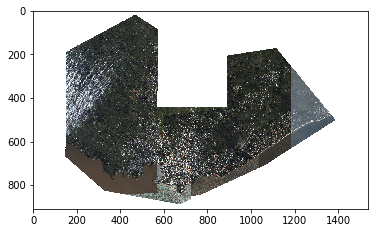

In [10]:
preview = mpimg.imread(os.path.join(DATA_DIR, 'mosaic_preview.png'))
plt.imshow(preview)

## Extract chips and labels from vector files

First define some useful functions for building R-Tree indexes and reprojecting shapes:

In [6]:
def create_index(shapes):
    """Create an R-Tree index from a set of shapes"""
    index = rtree.index.Index()
    for shape_id, shape in enumerate(shapes):
        index.insert(shape_id, shape.bounds)
    return index

def reproject_shape(shape, src_crs, dst_crs):
    """Reprojects a shape from some projection to another"""
    src_crs = dict(init=src_crs) if isinstance(src_crs, str) else src_crs
    dst_crs = dict(init=dst_crs) if isinstance(dst_crs, str) else dst_crs
    project = partial(
        pyproj.transform,
        pyproj.Proj(init=src_crs['init']),
        pyproj.Proj(init=dst_crs['init']))
    return transform(project, shape)

def get_raster_crs(raster_path):
    """Return CRS of +raster_path+"""
    with rasterio.open(raster_path) as dataset:
        return dataset.crs
    
def get_shapes(vector_path, target_crs=None):
    with fiona.open(vector_path) as dataset:
        shapes = (shape(f['geometry']) for f in dataset if f['geometry'])
        if dataset.crs != target_crs:
            shapes = (reproject_shape(s, dataset.crs, target_crs) for s in shapes)
        valid_shapes = [s for s in shapes if s.is_valid]
        return valid_shapes

def prepare_shapes_by_class(vectors_by_class, target_crs):
    """Load all shapes from each class vector file"""
    return {class_name: get_shapes(vector_file, target_crs)
            for class_name, vector_file in vectors_by_class.items()}

def prepare_index_by_class(shapes_by_class):
    """Build R-Tree index for all classes"""
    return {class_name: create_index(shapes)
            for class_name, shapes in shapes_by_class.items()}

In [7]:
# Load shapes for classes and build indexes for fast intersection
raster_crs = get_raster_crs(RASTER)
        
print("Loading shapes...")
shapes_by_class = prepare_shapes_by_class(VECTORS_BY_CLASS,
                                          target_crs=raster_crs['init'])
print("Building indexes...")
index_by_class = prepare_index_by_class(shapes_by_class)

print("Done")

Loading shapes...
Building indexes...
Done


In [8]:
def any_intersecting_shape(wbox, shapes, index):
    """Return true iif any shapes intersects with window, or is contained in window"""
    matching_shapes = [shapes[i] for i in index.intersection(wbox.bounds)]
    if matching_shapes:
        return any(shape.intersection(wbox) for shape in matching_shapes)
    else:
        return False

def get_window_labels(wbox, classes, *, shapes_by_class, index_by_class):
    labels = {}
    any_label = False
    for class_name in classes:
        shapes = shapes_by_class[class_name]
        index = index_by_class[class_name]
        labels[class_name] = any_intersecting_shape(wbox, shapes, index)
    return labels
        
def sliding_windows(size, step_size, width, height):
    """Slide a window of +size+ by moving it +step_size+ pixels"""
    w, h = size
    sw, sh = step_size
    for pos_i, i in enumerate(range(0, height - h + 1, sh)):
        for pos_j, j in enumerate(range(0, width - w + 1, sw)):
            yield Window(j, i, w, h), (pos_i, pos_j)

def write_image(img, path):
    rgb = np.dstack(img[:3, :, :])
    if is_low_contrast(rgb):
        return False
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imsave(path, rgb)
    return True

def convert_bools(labels):
    return {k: (1 if v else 0) for k, v in labels.items()}

def filter_by_aoi(window_and_boxes, aoi_vector):
    with fiona.open(aoi_vector) as src:
        shapes = [shape(f['geometry']) for f in src]
        assert len(shapes) == 1
        aoi_shape = shapes[0]
    return [w for w, b in window_and_boxes if aoi_shape.intersects(b)]

def build_dataset(raster, aoi_vector=None, *, classes, shapes_by_class, index_by_class, width, height, output_dir):
    with rasterio.open(raster) as ds:
        print('Raster size: {}'.format((ds.width, ds.height)))
        raster_crs = ds.crs

        size = (width, height)
        print("Building window list...")
        windows = list(sliding_windows(size, size, ds.width, ds.height))
        print("Windows: ", len(windows))

        print("Build window boxes...")
        windows_and_boxes = [(win, box(*ds.window_bounds(win[0]))) for win in windows]

        print("Filtering windows by AOI...")
        windows = filter_by_aoi(windows_and_boxes, aoi_vector)
        
        print("Windows after filtering by AOI: ", len(windows))
    
        labels_path = os.path.join(output_dir, 'labels.csv')
        os.makedirs(os.path.dirname(labels_path), exist_ok=True)
        
        with open(labels_path, 'w', newline='') as csvfile:
            fieldnames = ['img'] + list(classes)
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
        
            for window, (i, j) in tqdm_notebook(windows):
                #print(window, (i, j))
                img = ds.read(window=window)

                img_filename = '{i}_{j}.jpg'.format(i=i, j=j)
                img_path = os.path.join(output_dir, 'all', img_filename)
                was_image_written = write_image(img, img_path)

                if was_image_written:
                    # Get window labels
                    wbox = box(*ds.window_bounds(window))
                    labels = get_window_labels(wbox, classes, shapes_by_class=shapes_by_class, index_by_class=index_by_class)
                    labels = convert_bools(labels)

                    # Write labels to file
                    labels['img'] = img_filename
                    writer.writerow(labels)

In [14]:
build_dataset(RASTER,
              width=WIDTH,
              height=HEIGHT,
              aoi_vector=AOI_VECTOR,
              classes=CLASSES,
              shapes_by_class=shapes_by_class,
              index_by_class=index_by_class,
              output_dir=DATASET_DIR)

Raster size: (109149, 76345)
Building window list...
Windows:  92202
Build window boxes...
Filtering windows by AOI...
Windows after filtering by AOI:  45955


In [9]:
def parse_label_row(row):
    return [int(row[k]) for k in CLASSES]

def get_instances_and_labels_from_dataset(dataset_dir):
    labels_path = os.path.join(dataset_dir, 'labels.csv')
    with open(labels_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)
    X = np.array([row['img'] for row in rows])
    y = np.array([parse_label_row(row) for row in rows])
    return X, y

In [10]:
X, y = get_instances_and_labels_from_dataset(DATASET_DIR)

In [11]:
X, y

(array(['0_92.jpg', '0_93.jpg', '0_94.jpg', ..., '245_154.jpg',
        '245_155.jpg', '246_155.jpg'], dtype='<U11'), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]))

## Train-test split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Class balancing

First we analyze how many instances are from each class combination

In [14]:
y_train

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [15]:
CLASSES

('urban', 'rural', 'school')

In [29]:
def calculate_class_stats(y):
    total = y.shape[0]

    c_none = np.sum(np.all(y[:] == 0, axis=1))

    c_urban = np.sum(y[:, 0])
    c_rural = np.sum(y[:, 1])
    c_school = np.sum(y[:, 2])
    
    return np.array([total, c_none, c_urban, c_rural, c_school])

def print_class_stats(stats):
    total, c_none, c_urban, c_rural, c_school = tuple(stats)
    print("Total", total)
    print("None", c_none, c_none / total)
    print("Urban", c_urban, c_urban / total)
    print("Rural", c_rural, c_rural / total)
    print("School", c_school, c_school / total)
    
def plot_class_stats(stats):
    plt.bar(['none', 'urban', 'rural', 'school'], stats[1:])

Total 45267
None 23974 0.5296131839971724
Urban 10296 0.22745046060043742
Rural 12553 0.27731018181014866
School 318 0.007024985088475048


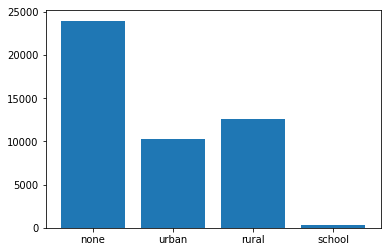

In [45]:
stats = calculate_class_stats(y)
print_class_stats(stats)
plot_class_stats(stats)

In [33]:
from sklearn.utils import class_weight

In [34]:
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

In [35]:
class_weights

array([  0.44148197,   1.37076993, 185.70769231])

Going to subsample to create a smaller but more balanced dataset

In [36]:
def balance_dataset(X, y):
    X_res, y_res = X[y[:, 2] == 1], y[y[:, 2] == 1]
    class_len = len(y_res) * 8
    indexes = [np.all(y == 0, axis=1), y[:, 0] == 1, y[:, 1] == 1]
    for idx in indexes:
        X_res = np.concatenate([X_res, X[idx][:class_len]])
        y_res = np.concatenate([y_res, y[idx][:class_len]])
    return X_res, y_res

In [37]:
X2, y2 = balance_dataset(X_train, y_train)

In [38]:
X2.shape, X_train.shape

((6400,), (36213,))

Total 6400
None 2048 0.32
Urban 2528 0.395
Rural 2413 0.37703125
School 308 0.048125


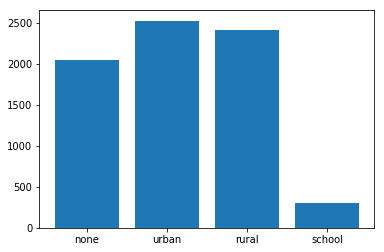

In [39]:
stats = calculate_class_stats(y2)
print_class_stats(stats)
plot_class_stats(stats)

In [40]:
X_train = X2
y_train = y2

In [41]:
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

In [42]:
class_weights

array([ 0.46620047,  1.21281031, 32.82051282])

In [43]:
X_train.shape, X_test.shape

((6400,), (9054,))

In [44]:
all_dir = os.path.abspath(os.path.join(DATASET_DIR, 'all'))
train_dir = os.path.abspath(os.path.join(DATASET_DIR, 'train'))
test_dir = os.path.abspath(os.path.join(DATASET_DIR, 'test'))

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for fname in X_train:
    shutil.copyfile(os.path.join(all_dir, fname), os.path.join(train_dir, fname))

for fname in X_test:
    shutil.copyfile(os.path.join(all_dir, fname), os.path.join(test_dir, fname))

## Plot some chips

In [79]:
urban_chips = X_train[y_train[:, 0] == 1]
rural_chips = X_train[y_train[:, 1] == 1]
school_chips = X_train[y_train[:, 2] == 1]

In [87]:
def plot_chip(img_filename):
    img_path = os.path.join(DATASET_DIR, 'train', img_filename)
    img = mpimg.imread(img_path)
    return plt.imshow(img)

def plot_some_chips(chips):
    # Get 9 random images of different classes, and plot them
    plt.figure(figsize=(12, 6))
    samples = np.random.choice(chips, 8)
    for i in range(1, 9):
        plt.subplot(2, 4, i)
        plt.axis('off')
        plot_chip(samples[i-1])

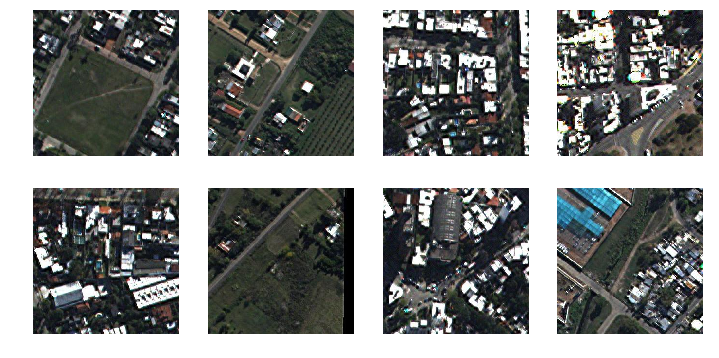

In [88]:
plot_some_chips(urban_chips)

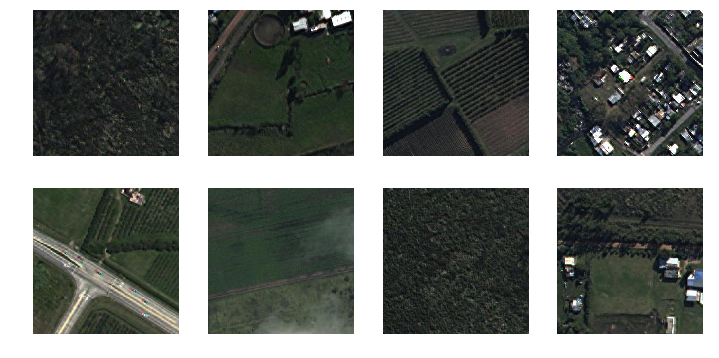

In [89]:
plot_some_chips(rural_chips)

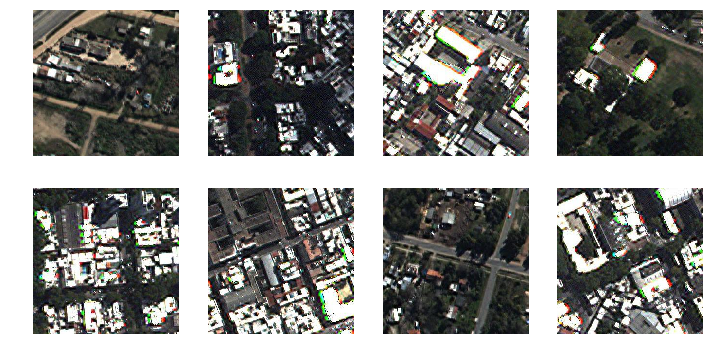

In [90]:
plot_some_chips(school_chips)

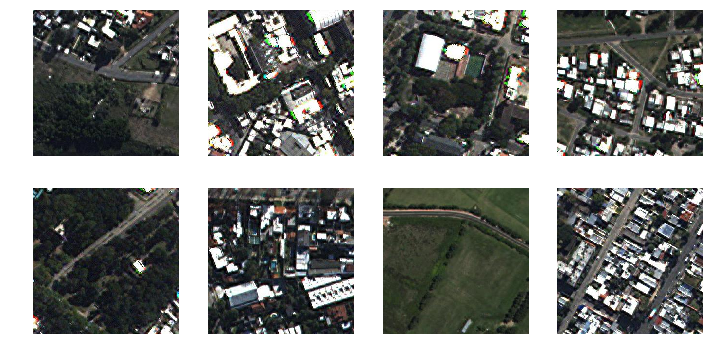

In [91]:
plot_some_chips(school_chips)